# 3D spectral analysis of HESS J1745-290 (with HAP-fr)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from astropy.convolution import Tophat2DKernel
from regions import CircleSkyRegion, RectangleSkyRegion

from astropy.time import Time

In [2]:
#from gammapy.detect import compute_lima_on_off_image,compute_lima_image # quelle différence entre les deux ?

from gammapy.data import DataStore
from gammapy.irf import PSFKernel
from gammapy.maps import Map, MapAxis, WcsGeom
from gammapy.datasets import MapDataset, Datasets, FluxPointsDataset
from gammapy.makers import (
    MapDatasetMaker,
    SafeMaskMaker,
    FoVBackgroundMaker,
)
from gammapy.modeling import Fit
from gammapy.modeling.models import (
    Models,
    SkyModel,
    BackgroundModel,
    PowerLawSpectralModel,
    PowerLaw2SpectralModel,
    PointSpatialModel,
    ExpCutoffPowerLawSpectralModel,
    TemplateSpatialModel,
    GaussianSpatialModel,
    FoVBackgroundModel
)
#from gammapy.stats import significance, excess # utiles ?
from gammapy.estimators import (
    #LiMaMapEstimator,
    TSMapEstimator,
    ExcessMapEstimator,
    FluxPointsEstimator
)


import gammapy
gammapy.__version__

'0.18.2'

In [3]:
from pathlib import Path

# General path (to select which analysis/set of data we work with)
path = Path("../../../hess_results/GC_variability_0.18.2/hap-fr")
path.mkdir(exist_ok=True)

pathma = Path(path/"mapdatasets")
pathma.mkdir(exist_ok=True)

# To find the model template
pathm = Path(path/"models")
pathm.mkdir(exist_ok=True)

model_name = pathm/"models_template_2cutoff.yaml"

# Directory for outputs
path3d = Path(path/"3Dspectra")
path3d.mkdir(exist_ok=True)

In [4]:
pathtry = Path(path3d/"2amps_2indexes_2cutoff")
pathtry.mkdir(exist_ok=True)

In [5]:
src_pos = SkyCoord(359.94, -0.04, unit="deg", frame="galactic")

## Creating the geometry

In [6]:
emin, emax = [0.5, 100] * u.TeV

e_bins = 20

energy_axis = MapAxis.from_energy_bounds(
    emin.value, emax.value, e_bins, unit="TeV"
)
geom = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    frame="galactic",
    proj="CAR",
    axes=[energy_axis],
)

geom2d = WcsGeom.create(
    skydir=(0, 0),
    binsz=0.02,
    width=(10, 8),
    frame="galactic",
    proj="CAR",
)

emintrue, emaxtrue = [0.3,200] * u.TeV
e_bins_true = 30

energy_axis_true = MapAxis.from_energy_bounds(
    emintrue.value, emaxtrue.value, e_bins_true, unit="TeV", name="energy_true"
)

In [7]:
# Creating the total dataset (potentially useless)

mapdataset_tot = MapDataset.create(geom=geom, energy_axis_true=energy_axis_true)

filename = "mapdataset_tot.fits.gz"
mapdataset_tot = MapDataset.read(pathma/filename)

In [8]:
datasets_period = Datasets.read(pathma/"datasets_period.yaml")

## Reading the model template

In [9]:
modelGC,modelG09, model_diff = Models.read(model_name)

## Setting which parameters will vary

In [10]:
modelGC.parameters["index"].frozen = False
modelGC.parameters["index"].value = 1.83

modelGC.parameters["lon_0"].frozen = True
modelGC.parameters["lat_0"].frozen = True
modelGC.parameters["amplitude"].frozen = False
modelGC.parameters["reference"].frozen = True 

modelG09.parameters["index"].frozen = True
modelG09.parameters["lat_0"].frozen = True
modelG09.parameters["amplitude"].frozen = False

model_diff.parameters["index"].frozen = False
model_diff.parameters["index"].value = 2.3

#model_diff.parameters["norm"].frozen = True
model_diff.parameters["amplitude"].frozen = False
model_diff.parameters["reference"].frozen = True

In [11]:
# if there are cutoffs in the spectra

modelGC.parameters["lambda_"].frozen = False
modelGC.parameters["lambda_"].value = 1/8.77

model_diff.parameters["lambda_"].frozen = False
model_diff.parameters["lambda_"].value = 1/20.0

## Constructing the mask

In [12]:
fit_region = RectangleSkyRegion(src_pos, 4*u.deg, 2*u.deg)

#éventuellement étendre le masque

J1745_303_region = CircleSkyRegion(SkyCoord(358.6,  -0.6, unit="deg", frame="galactic"), 0.5 * u.deg)

fit_mask = geom.region_mask([fit_region])*geom.region_mask([J1745_303_region] , inside=False)

fit_mask = Map.from_geom(geom, data=fit_mask)

## Function used to fit a given dataset

In [13]:
def fit_dataset(fit):

    result = fit.run()
    
    table = result.parameters.to_table()
    
    return table, result

# Fitting the many datasets

Stacking all three datasets tends to give poor results, trying to fit HESS1+2 on the one hand, and HESS1U on the other might be more succesful.

### Fitting the dataset for each period separately

In [34]:
%%time

datasets_period['hess1'].fit_mask = fit_mask
datasets_period['hess1'].models =  modelGC.copy() + modelG09.copy()+ model_diff.copy()
bkg_model = FoVBackgroundModel(dataset_name = datasets_period['hess1'].name)

datasets_period['hess2'].fit_mask = fit_mask
datasets_period['hess2'].models =  modelGC.copy() + modelG09.copy()+ model_diff.copy()
bkg_model = FoVBackgroundModel(dataset_name = datasets_period['hess2'].name)

datasets_period['hess1u'].fit_mask = fit_mask
datasets_period['hess1u'].models =  modelGC.copy() + modelG09.copy()+ model_diff.copy()
bkg_model = FoVBackgroundModel(dataset_name = datasets_period['hess1u'].name)

fit1 = Fit([datasets_period['hess1']])
table1,  result1 = fit_dataset(fit1)

models_hess1 = datasets_period['hess1'].models.copy()

fit2 = Fit([datasets_period['hess2']])
table2,  result2 = fit_dataset(fit2)

models_hess2 = datasets_period['hess2'].models.copy()

fit1u = Fit([datasets_period['hess1u']])
table1u,  result1u = fit_dataset(fit1u)

models_hess1u = datasets_period['hess1u'].models.copy()

CPU times: user 2min 46s, sys: 1.52 s, total: 2min 48s
Wall time: 2min 48s


### Fitting the joint dataset

In [15]:
%%time

joint_dataset = [datasets_period['hess1'], datasets_period['hess2'], datasets_period['hess1u']]
for dataset in joint_dataset:
    dataset.models = modelGC.copy() + modelG09.copy()+ model_diff.copy()
    dataset.fit_mask = fit_mask
    bkg_model = FoVBackgroundModel(dataset_name = dataset.name)

fit_joint = Fit(joint_dataset)
table_joint, result_joint = fit_dataset(fit_joint)

CPU times: user 2min 38s, sys: 12 s, total: 2min 50s
Wall time: 2min 51s


### Joint dataset without HESS1u

In [26]:
%%time

joint_dataset12 = [datasets_period['hess1'], datasets_period['hess2']]  
for dataset in joint_dataset12:
    dataset.models = modelGC.copy() + modelG09.copy()+ model_diff.copy()
    dataset.fit_mask = fit_mask
    bkg_model = FoVBackgroundModel(dataset_name = dataset.name)

fit_joint12 = Fit(joint_dataset12)
table_joint12, result_joint12 = fit_dataset(fit_joint)

models_joint12 = joint_dataset12[0].models.copy()

CPU times: user 18.6 s, sys: 1.84 s, total: 20.4 s
Wall time: 20.4 s


In [30]:
result_joint12

OptimizeResult

	backend    : minuit
	method     : minuit
	success    : False
	message    : Optimization failed.
	nfev       : 40
	total stat : 1363938.78

### Fitting the stacked dataset

In [31]:
%%time

mapdataset_tot.fit_mask = fit_mask
mapdataset_tot.models =  modelGC.copy() + modelG09.copy()+ model_diff.copy()
bkg_model = FoVBackgroundModel(dataset_name = mapdataset_tot.name)


fit_tot = Fit([mapdataset_tot])
table_tot, result_tot = fit_dataset(fit_tot)

CPU times: user 37.4 s, sys: 4.76 s, total: 42.1 s
Wall time: 42.2 s


## Results

### Spectrum

In [40]:
def plot_spectrum(models, path ,namefile, name):
    plt.figure(figsize=(12,8))
    plot_kwargs = {
        "energy_range": [0.1, 30] * u.TeV,
        "energy_power": 2,
        "flux_unit": "erg-1 cm-2 s-1",
    }

    ## central source
    index = models[0].spectral_model.parameters["index"].value
    amp = models[0].spectral_model.parameters["amplitude"].value
    
    if models[0].spectral_model.parameters["lambda_"].value != 0:
        cutoff = 1/models[0].spectral_model.parameters["lambda_"].value
        models[0].spectral_model.plot(
        **plot_kwargs, label=r"J1745-290 : index = {0:03.3f} , amplitude = {1:03.2f}e-12 (cm^2 s TeV)^-1, cutoff = {2:03.3f} TeV".format(index, 10**12*amp, 1/cutoff))
    else :  
        models[0].spectral_model.plot(
        **plot_kwargs, label=r"J1745-290 : index = {0:03.3f} , amplitude = {1:03.2f}e-12 (cm^2 s TeV)^-1".format(index, 10**12*amp ))
    models[0].spectral_model.plot_error(**plot_kwargs)

    
    ## diffuse model
    index = models[2].spectral_model.parameters["index"].value
    amp = models[2].spectral_model.parameters["amplitude"].value
    
    if models[2].spectral_model.parameters["lambda_"].value != 0:
        cutoff = 1/models[2].spectral_model.parameters["lambda_"].value
        models[2].spectral_model.plot(
        **plot_kwargs, label=r"diffuse   : index = {0:03.3f} , amplitude = {1:03.2f}e-12 (cm^2 s TeV)^-1, cutoff = {2:03.3f} TeV".format(index, 10**12*amp, 1/cutoff ))
    else :  
        models[2].spectral_model.plot(
        **plot_kwargs, label=r"diffuse   : index = {0:03.3f} , amplitude = {1:03.2f}e-12 (cm^2 s TeV)^-1".format(index, 10**12*amp ))
    models[2].spectral_model.plot_error(**plot_kwargs)

    plt.title("Spectral models fitted for a constant GC source (" + name + ")")
    plt.legend()
    #plt.savefig(path/namefile)

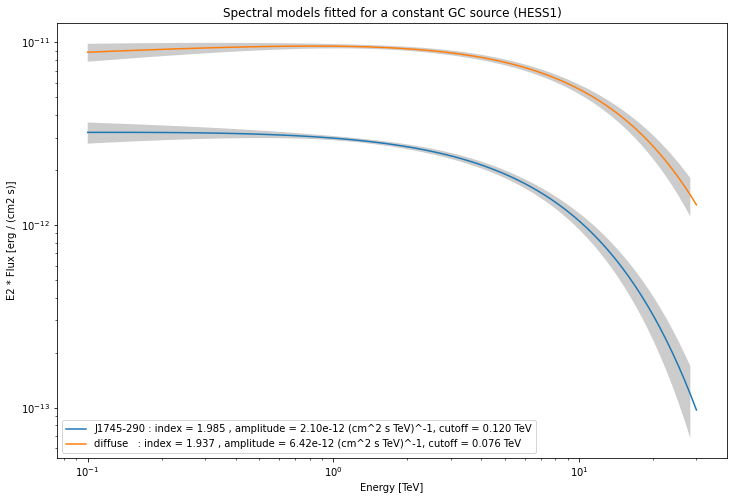

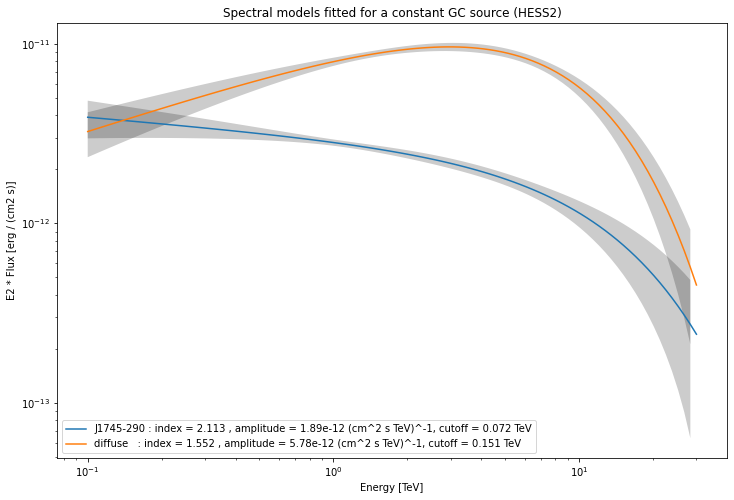

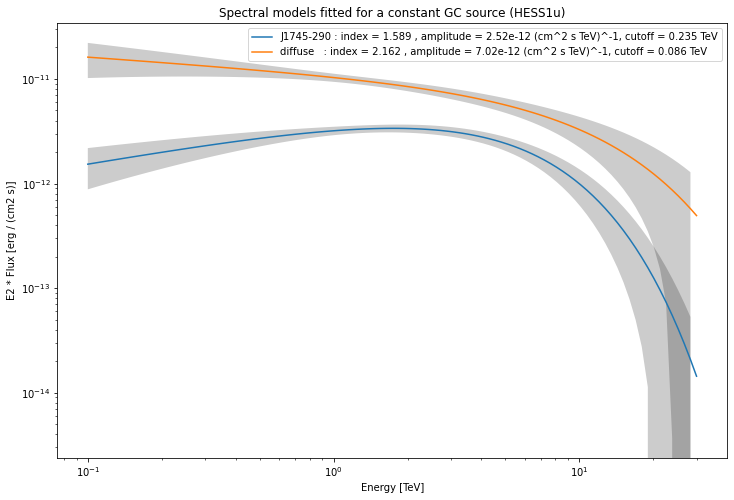

In [41]:
plot_spectrum(models_hess1,  pathtry,"hess1_model_2cutoff_fr.pdf", "HESS1")
plot_spectrum(models_hess2,  pathtry,"hess2_model_2cutoff_fr.pdf", "HESS2")
plot_spectrum(models_hess1u, pathtry,"hess1u_model_2cutoff_fr.pdf", "HESS1u")

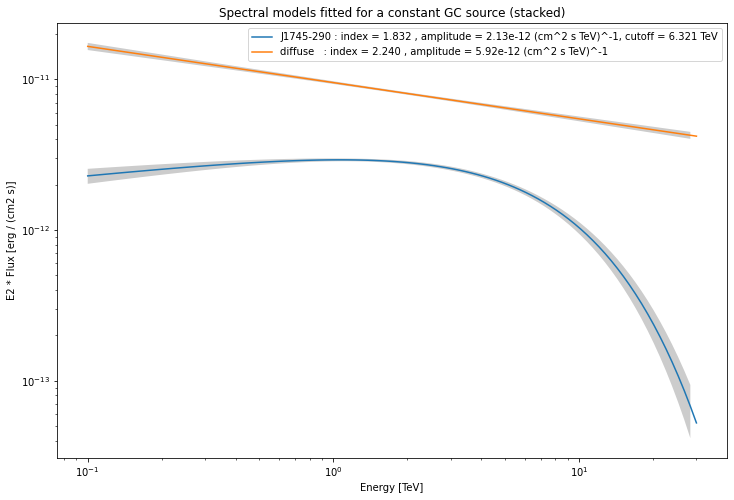

In [33]:
plot_spectrum(mapdataset_tot.models, pathtry,"stacked_model_2cutoff_fr.pdf", "stacked")

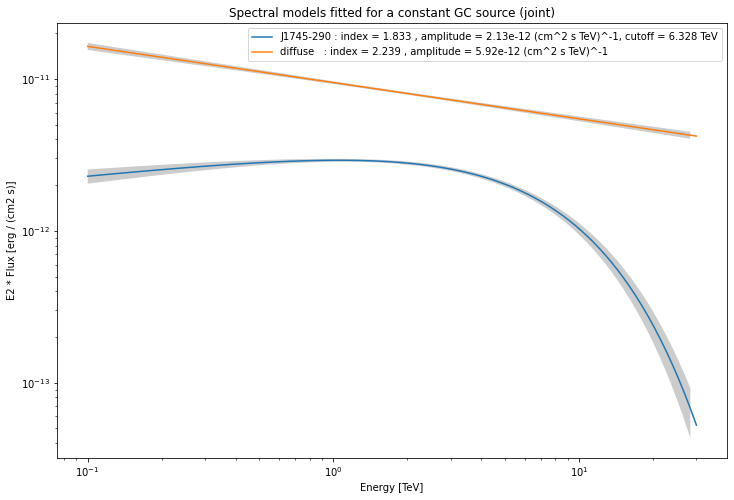

In [34]:
plot_spectrum(models_joint, pathtry,"joint_model_2cutoff_fr.pdf","joint")

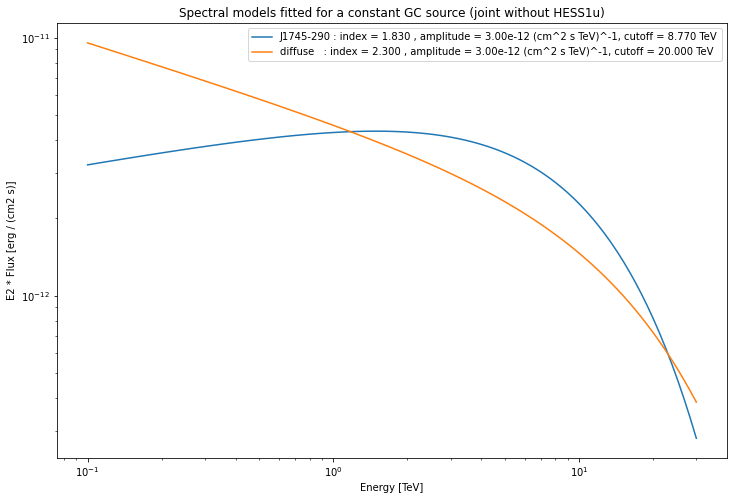

In [27]:
plot_spectrum(models_joint12, pathtry,"joint_model_2cutoff_fr_12.pdf","joint without HESS1u")

## Flux points

In [20]:
pathFP = Path(pathtry/"fluxpoints")
pathFP.mkdir(exist_ok=True)

In [21]:
def FluxPointsFitting(datasets, num, e_edges, namefile):
    # this function has to be given the number of the source model in case of multiple models
    # more parameters exist to initialise the estimator
    
    fpe = FluxPointsEstimator( energy_edges=e_edges, source =num) 
    flux_points = fpe.run(datasets=datasets)
    flux_points_dataset = FluxPointsDataset(data=flux_points, models=dataset.models[num])
    plt.figure(figsize=(8, 6))
    flux_points_dataset.plot_fit()
    name = "fluxpoints_"+namefile+".pdf"
    plt.savefig(pathFP/name)
    
def DoubleFluxPointsFitting(datasets, e_edges, namefile):
    # plots source flux points and DE flux points at once, without the residuals thingy
    
    fpe = FluxPointsEstimator( energy_edges=e_edges, source = 0) 
    flux_points = fpe.run(datasets=datasets)
    flux_points_dataset_GC = FluxPointsDataset(data=flux_points, models=datasets.models[0])

    fpe = FluxPointsEstimator( energy_edges=e_edges, source = 2) 
    flux_points = fpe.run(datasets=datasets)
    flux_points_dataset_DE = FluxPointsDataset(data=flux_points, models=datasets.models[2])
    
    plt.figure(figsize=(8,6))

    flux_points_dataset_GC.plot_spectrum()
    flux_points_dataset_DE.plot_spectrum()
    
    name = "fluxpoints_"+namefile+".pdf"
    plt.savefig(pathFP/name)

In [22]:
e_min, e_max = 0.5, 30
e_edges = np.logspace(np.log10(e_min), np.log10(e_max), 11) * u.TeV

In [ ]:
DoubleFluxPointsFitting(datasets_period, e_edges, "joint_2cutoff_fr")

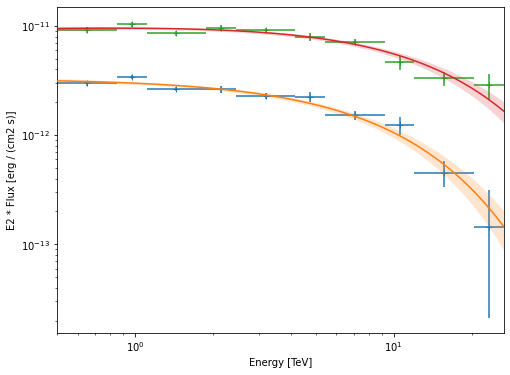

In [35]:
DoubleFluxPointsFitting(datasets_period['hess1'], e_edges, "hess1_2cutoff_fr")

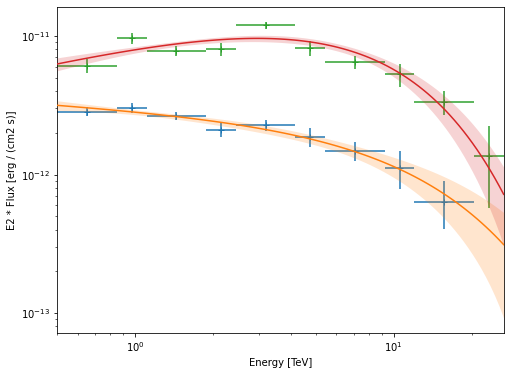

In [37]:
DoubleFluxPointsFitting(datasets_period['hess2'], e_edges, "hess2_2cutoff_fr")

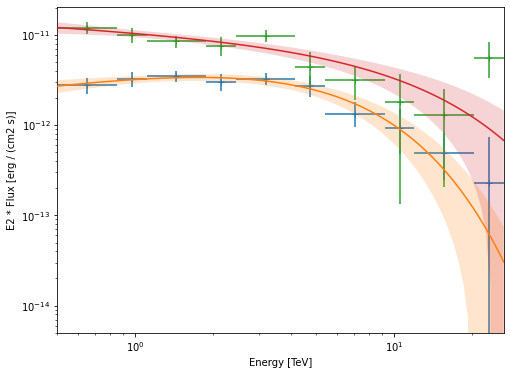

In [38]:
DoubleFluxPointsFitting(datasets_period['hess1u'], e_edges, "hess1u_2cutoff_fr")

## Maps

In [35]:
mapdataset_tot.models = models_joint

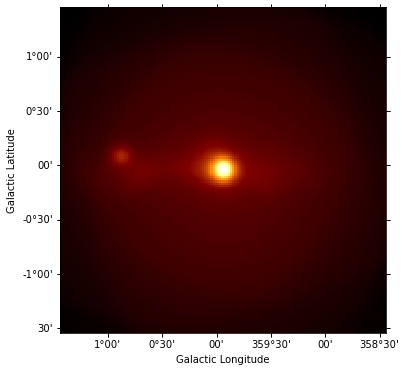

In [36]:
plt.figure(figsize=(6,6))
mapdataset_tot.npred().sum_over_axes().cutout(src_pos,3*u.deg).smooth('0.05 deg').plot()
#plt.plot((0,0), '*', color='black')
plt.savefig(pathtry/"model_tot_map.pdf")

## Residuals

In [37]:
region = CircleSkyRegion(
    center=src_pos, radius=0.5 * u.deg
)

kwargs_spatial = {} #{'vmin':-1, 'vmax':1 } # nécessaire ?

kwargs_spectral = {'method':'diff/sqrt(model)', 'region' : CircleSkyRegion(center=src_pos, radius=0.3 * u.deg)}

def residuals(dataset, namefile, namefig):
    dataset.plot_residuals(kwargs_spatial=kwargs_spatial, kwargs_spectral=kwargs_spectral)
    #plt.plot((0,0), '*')
    plt.title("residuals (diff/sqrt(model)) " + namefig)
    name = "residuals_" + namefile +"_fr.pdf"
    plt.savefig(pathtry/name, overwrite=True)

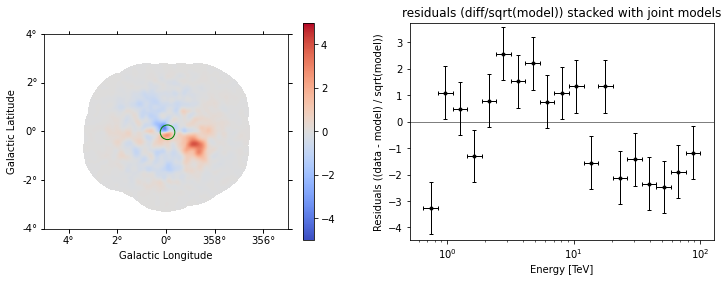

In [38]:
residuals(mapdataset_tot,"stacked", "stacked with joint models")

## Significance map

In [39]:
from scipy.stats import norm


def significance(dataset, namefile, namefig):
    #plt.figure(figsize=(6,6))

    lima_estimator = ExcessMapEstimator("0.2 deg", selection_optional=[] )
    
    res =  lima_estimator.run(dataset)
    
    res['sqrt_ts'].plot(add_cbar=True)
    #plt.plot((0,0), '*')
    
    namepdf = "significance_"+namefile+"_fr.pdf"
    namefits = "significance_"+namefile+"_fr.fits"
    
    plt.title("Significance map (data v. predictions) "+namefig)
    
    plt.savefig(pathtry/namepdf, overwrite=True)
    res['sqrt_ts'].write(pathtry/namefits, overwrite=True)
    
    
    plt.figure()
    signidata = res['sqrt_ts'].cutout(position=src_pos, width=(3 * u.deg, 1.5* u.deg)).data
    
    # on masque la région en bas à droite
    mask = fit_mask.reduce_over_axes(func=np.logical_or).cutout(position=src_pos, width=(3 * u.deg, 1.5* u.deg)).data
    
    signidata_masked = signidata[0,mask]
    
    plt.hist(signidata_masked.flatten(),30, histtype='step', density=True)
    
    # what about cutting values above 5/below -5 ?
    x = np.abs(signidata_masked) < 5
    mean,std=norm.fit(signidata_masked[x])
    
    
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    y = norm.pdf(x, mean, std)
    plt.plot(x, y, label=r'$\mu$ = {0:03.4f}, $\sigma$ = {1:03.4f}'.format(mean,std))
    y2= norm.pdf(x, 0, 1)   
    plt.plot(x, y2 ,label=r'$\mu$ = 0, $\sigma$ = 1')
    
    plt.legend()
    
    name = "significance_hist_"+namefile+"_fr.pdf"
    plt.title("Significance distribution on the central (3°,1.5°) "+namefig)
    plt.savefig(pathtry/name, overwrite=True)

/home/samuel/anaconda3/envs/gammapy-0.18.2/lib/python3.7/site-packages/astropy/units/quantity.py:477: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


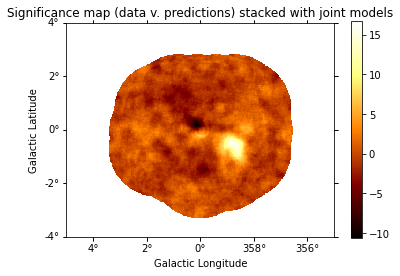

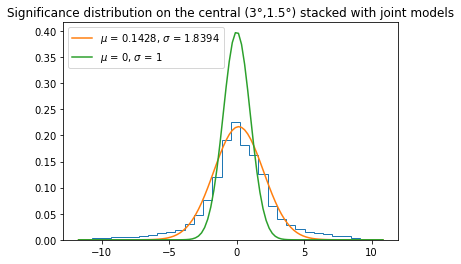

In [40]:
significance(mapdataset_tot,"stacked", "stacked with joint models")

## Properly estimating the error on the parameter (using likelihood)

In [ ]:
with open(pathtry/'errors.txt', "a") as out:
    out.write("")
    
dataset = joint_dataset
models = models_joint
table = table_joint

In [ ]:
%%time

param = models[0].spectral_model.parameters["index"]

if param.frozen == False:
    fit = Fit(dataset)

    fit.optimize()
    confresult = fit.confidence(parameter = param, sigma=1)
    
    with open(pathtry/'errors.txt', "a") as out:
        out.write(
            "GC index = {0:03.3f}, errp = {1:03.3f}, errn = {2:03.3f}, err_naive = {3:03.3f}".format(
                param.value, confresult['errp'], confresult['errp'], table['error'][2]
            )  + "\n"
        )

In [ ]:
%%time

param = models[2].spectral_model.parameters["index"]

if param.frozen == False:
    fit = Fit(dataset)

    fit.optimize()
    confresult = fit.confidence(parameter = param, sigma=1)

    with open(pathtry/'errors.txt', "a") as out:
        out.write(
            "DE index = {0:03.3f}, errp = {1:03.3f}, errn = {2:03.3f}, err_naive = {3:03.3f}".format(
                param.value, confresult['errp'], confresult['errp'], table['error'][13]
            )  + "\n"
        )

In [ ]:
%%time

param = models[0].spectral_model.parameters["lambda_"]

if param.frozen == False:
    fit = Fit(dataset)

    fit.optimize()
    confresult = fit.confidence(parameter = param, sigma=1)

    with open(pathtry/'errors.txt', "a") as out:
        out.write(
            "GC lambda = {0:03.4f}, errp = {1:03.4f}, errn = {2:03.4f}, err_naive = {3:03.4f}".format(
                param.value, confresult['errp'], confresult['errp'], table['error'][5]
            )  + "\n"
        )

In [ ]:
%%time

param = models[2].spectral_model.parameters["lambda_"]

if param.frozen == False:
    
    fit = Fit(dataset)

    fit.optimize()
    confresult = fit.confidence(parameter = param, sigma=1)

    with open(pathtry/'errors.txt', "a") as out:
        out.write(
            "DE lambda = {0:03.4f}, errp = {1:03.4f}, errn = {2:03.4f}, err_naive = {3:03.4f}".format(
                param.value, confresult['errp'], confresult['errp'], table['error'][16]
            )  + "\n"
        )

In [ ]:
param = models[0].spectral_model.parameters["amplitude"]

with open(pathtry/'errors.txt', "a") as out:
    out.write(
        "GC ampli = {0:03.4e}, err_naive = {1:03.4e}".format(
            param.value, table['error'][3]
        )  + "\n"
    )


param = models[2].spectral_model.parameters["amplitude"]

with open(pathtry/'errors.txt', "a") as out:
    out.write(
        "DE ampli = {0:03.4e}, err_naive = {1:03.4e}".format(
            param.value, table['error'][14]
        )  + "\n"
    )